In [1]:
import os
import sys
import warnings
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[1].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

from obsrv_plan.general.params import DATA_FILE_PATH, MAX_PARALLEL, WORKING_DIR

import time
import random
# import requests
import csv

from multiprocessing import Pool, Lock

SPLITS_DIR = os.path.join(WORKING_DIR, "splits")
os.makedirs(SPLITS_DIR, exist_ok=True)

LOCK = Lock()
MAX_PARALLEL = 10

In [2]:
print(WORKING_DIR)

/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4


In [3]:
import math

def writeSplit(lines: list[str], header: str, split: int) -> str:
	splitFilePath = os.path.join(SPLITS_DIR, f"{split}.csv")
	print(f"Writing split {split} to {splitFilePath}")	
	with open(splitFilePath, 'w+') as splitFile:
		splitFile.write(header + "\n")
		splitFile.writelines(lines)
	print("Finished writing split")
	return splitFilePath

splitCsvFiles = [os.path.join(SPLITS_DIR, f) for f in os.listdir(SPLITS_DIR)] # don't try to split if files already present
if len(splitCsvFiles) == 0:
	totalNumRows = 3_239_305 # wc -l "SDSS 3_4 Filter GDR3-result.csv"
	split = math.ceil(totalNumRows / MAX_PARALLEL)
	with open(DATA_FILE_PATH, 'r') as targetsCsv:
		isReadingHeader = True
		header: str
		curSplitLines = []
		curSplit = 0
		for lineList in csv.reader(targetsCsv):
			rawLine = ",".join(lineList) + '\n'
			if isReadingHeader:
				header = rawLine
				isReadingHeader = False
			else:
				curSplitLines.append(rawLine)

			if len(curSplitLines) == split:
				splitCsvFiles.append(writeSplit(curSplitLines, header, curSplit))
				curSplitLines.clear()
				curSplit += 1

	if len(curSplitLines) != 0:
		splitCsvFiles.append(writeSplit(curSplitLines, header, curSplit))
splitCsvFiles

['/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/00.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/01.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/02.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/03.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/04.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/05.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/06.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/07.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/08.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/09.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/10.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/11.csv',
 '/home/ramon/uanl/Tesis/Bac

In [4]:
def printSync(stringPrint: str) -> None:
	with LOCK:
		print(os.getpid(), stringPrint)

class StarRecord:

	def __init__(self, gaia_source_id: str, simbad_id: str, ra: float, dec: float, type: str) -> None:
		self.gaia_source_id = gaia_source_id
		self.simbad_id = simbad_id
		self.ra = ra
		self.dec = dec
		self.type = type

	def to_dict(self) -> dict[str, str]:
		return {
			"gaia_source_id": self.gaia_source_id,
			"simbad_id": self.simbad_id,
			"ra": str(self.ra),
			"dec": str(self.dec),
			"type": self.type
		}

	def __str__(self) -> str:
		return f"gid={self.gaia_source_id}, sid={self.simbad_id}, ra={self.ra}, dec={self.dec}, type={self.type}"
	
	def __repr__(self) -> str:
		return str(self)

In [8]:
from astroquery.simbad import Simbad
from astropy.table.table import Table

customSimbad = Simbad()
customSimbad.add_votable_fields('otype', 'ids')

def querySimbad(source_ids_batch: list[str]) -> Table:
	with warnings.catch_warnings(action='ignore'):
		triesRemaining = 3
		while True:
			if triesRemaining == 0:
				return Table() # return empty table
			triesRemaining -= 1
			try:
				return customSimbad.query_objects(source_ids_batch)
			except:
				printSync(f"SIMBAD query failed. Retrying {triesRemaining} more {('times' if triesRemaining > 1 else 'time')}.")
				time.sleep(random.randint(3, 5))

def getGaiaSourceId(ids) -> str:
	for s_id in ids:
		if 'Gaia DR3' in s_id:
			return s_id.replace('Gaia DR3 ', '')

def toStarRecords(batch_results: Table) -> list[StarRecord]:
	starRecords: list[StarRecord] = []
	for i in range(len(batch_results)):
		row = batch_results[i]
		gaiaSourceId = getGaiaSourceId(row['IDS'].split('|'))
		starRecords.append(StarRecord(gaia_source_id=gaiaSourceId, simbad_id=row['MAIN_ID'], ra=row['RA'], dec=row['DEC'], type=row['OTYPE']))
	return starRecords

def processSources(starRows: csv.reader) -> list[StarRecord]:
	header = next(starRows)
	sid_idx = header.index("source_id")

	starRecords: list[StarRecord] = []
	queryBatch = []
	failedSources = 0
	for row in starRows:
		queryBatch.append(f"Gaia DR3 {row[sid_idx]}")
		if len(queryBatch) == 2000:
		# if len(queryBatch) == 20:
			time.sleep(random.randint(3, 10)) # prevent spamming SIMBAD
			tableResults = querySimbad(queryBatch)
			starRecords += toStarRecords(tableResults)
			failedSources += len(queryBatch) - len(tableResults)
			queryBatch.clear()
			printSync(f"Processed {(len(starRecords) + failedSources)} sources | {failedSources} sources without match in SIMBAD.")
	tableResults = querySimbad(queryBatch)
	failedSources += len(queryBatch) - (len(tableResults) if tableResults else 0)
	printSync(f"Found {len(starRecords)} records. Failed to find data for {failedSources} GDR3 sources.")
	return starRecords

def multiProcessSources(sourcesCsvFilePath: str):
	printSync(sourcesCsvFilePath)
	with open(sourcesCsvFilePath, 'r') as file:
		starRows = csv.reader(file)
		try:
			return processSources(starRows)
		except Exception as e:
			with LOCK:
				print(sourcesCsvFilePath, e)
			raise e

with Pool(MAX_PARALLEL) as p:
	resultLists = p.map(multiProcessSources, splitCsvFiles)

simbadStars = [item for sublist in resultLists for item in sublist]
# simbadStars

440463 /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/00.csv
440464 /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/01.csv
440465 /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/02.csv
440466 /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/03.csv
440467 /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/04.csv
440468 /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/05.csv
440469 /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/06.csv
440470 /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/07.csv
440471 /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/08.csv
440472 /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-3_4/splits/09.csv
440463 Processed 2000 sources | 1189 sources without match in SIMBAD.
440464 Processed 2000 sources | 819 sources without match in SIMBAD.
440471 Processed 2000

In [10]:
categories = {}
for starRecord in simbadStars:
	starTypeList = categories.get(starRecord.type, [])
	starTypeList.append(starRecord.to_dict())
	categories[starRecord.type] = starTypeList

# categories

In [11]:
import json

starCategoriesJson = os.path.join(WORKING_DIR, "categories.json")
with open(starCategoriesJson, 'w+') as file:
	json.dump(categories, file)

In [14]:
categoryCountsDict = {cat:len(records) for cat, records in categories.items()}
categoryCountsDict

{'LongPeriodV*_Candidate': 1204168,
 'LongPeriodV*': 384771,
 'Mira': 76257,
 'RRLyrae': 46051,
 'RCrBV*': 100,
 'ClassicalCep': 2546,
 'YSO': 3756,
 'HighPM*': 6478,
 'EmLine*': 769,
 'OrionV*': 393,
 'Star': 8101,
 'YSO_Candidate': 7960,
 'EclBin': 28735,
 'Mira_Candidate': 21,
 'SB*': 500,
 'OH/IR*': 732,
 'C*': 14151,
 'HorBranch*': 17,
 'S*': 944,
 '**': 104,
 'RedSG': 781,
 'PulsV*': 62,
 'Variable*': 2202,
 'AGB*_Candidate': 1264,
 'Type2Cep': 519,
 'BYDraV*': 230,
 'EclBin_Candidate': 466,
 'AGB*': 1469,
 'RSCVnV*': 305,
 'RGB*': 251,
 'WolfRayet*': 75,
 'BlueSG': 41,
 'post-AGB*_Candidate': 21,
 'C*_Candidate': 169,
 'Symbiotic*': 154,
 'TTauri*': 937,
 'Low-Mass*': 408,
 'NearIR': 46,
 'RVTauV*': 176,
 'EllipVar': 2764,
 'delSctV*': 67,
 'post-AGB*': 46,
 'RRLyrae_Candidate': 67,
 'Be*': 12,
 'Infrared': 19,
 'X': 32,
 'PlanetaryNeb_Candidate': 23,
 'FarIR': 2,
 'Supergiant': 5,
 'ChemPec*': 109,
 'RotV*': 505,
 'Nova': 15,
 'Eruptive*': 184,
 'S*_Candidate': 16,
 'Cepheid': 

In [15]:
categoryCounts = [(cat, count) for cat, count in categoryCountsDict.items()]
categories = [cat for cat, _ in categoryCounts]
counts = [count for _, count in categoryCounts]
categoryCounts

[('LongPeriodV*_Candidate', 1204168),
 ('LongPeriodV*', 384771),
 ('Mira', 76257),
 ('RRLyrae', 46051),
 ('RCrBV*', 100),
 ('ClassicalCep', 2546),
 ('YSO', 3756),
 ('HighPM*', 6478),
 ('EmLine*', 769),
 ('OrionV*', 393),
 ('Star', 8101),
 ('YSO_Candidate', 7960),
 ('EclBin', 28735),
 ('Mira_Candidate', 21),
 ('SB*', 500),
 ('OH/IR*', 732),
 ('C*', 14151),
 ('HorBranch*', 17),
 ('S*', 944),
 ('**', 104),
 ('RedSG', 781),
 ('PulsV*', 62),
 ('Variable*', 2202),
 ('AGB*_Candidate', 1264),
 ('Type2Cep', 519),
 ('BYDraV*', 230),
 ('EclBin_Candidate', 466),
 ('AGB*', 1469),
 ('RSCVnV*', 305),
 ('RGB*', 251),
 ('WolfRayet*', 75),
 ('BlueSG', 41),
 ('post-AGB*_Candidate', 21),
 ('C*_Candidate', 169),
 ('Symbiotic*', 154),
 ('TTauri*', 937),
 ('Low-Mass*', 408),
 ('NearIR', 46),
 ('RVTauV*', 176),
 ('EllipVar', 2764),
 ('delSctV*', 67),
 ('post-AGB*', 46),
 ('RRLyrae_Candidate', 67),
 ('Be*', 12),
 ('Infrared', 19),
 ('X', 32),
 ('PlanetaryNeb_Candidate', 23),
 ('FarIR', 2),
 ('Supergiant', 5),


In [1]:
%%script echo "skipping; no need to trim at this point"
trimmedCategories = {"Misc.": 0}
for cat, count in categoryCounts:
	if count < 10:
		trimmedCategories["Misc."] += count
	else:
		trimmedCategories[cat] = count

categoryCounts = [(cat, count) for cat, count in trimmedCategories.items()]
categories = [cat for cat, _ in categoryCounts]
counts = [count for _, count in categoryCounts]

skipping; no need to trim at this point


In [25]:
categoryCounts, categories

([('Misc.', 86),
  ('Variable*', 173),
  ('Mira', 329),
  ('LongPeriodV*', 213),
  ('EclBin_Candidate', 27),
  ('Star', 1471),
  ('Galaxy', 29),
  ('LongPeriodV*_Candidate', 323),
  ('S*', 26),
  ('YSO_Candidate', 116),
  ('RRLyrae_Candidate', 10),
  ('WhiteDwarf_Candidate', 47),
  ('EclBin', 12),
  ('Infrared', 35),
  ('AGB*', 10),
  ('Radio', 92),
  ('HighPM*', 39),
  ('C*', 50),
  ('SB*', 42),
  ('X', 16),
  ('FarIR', 29),
  ('RGB*', 45),
  ('DarkNeb', 41),
  ('PulsV*', 26),
  ('HorBranch*', 14),
  ('MolCld', 27),
  ('**', 20),
  ('ClassicalCep', 12),
  ('EmLine*', 22),
  ('C*_Candidate', 21),
  ('YSO', 205)],
 ['Misc.',
  'Variable*',
  'Mira',
  'LongPeriodV*',
  'EclBin_Candidate',
  'Star',
  'Galaxy',
  'LongPeriodV*_Candidate',
  'S*',
  'YSO_Candidate',
  'RRLyrae_Candidate',
  'WhiteDwarf_Candidate',
  'EclBin',
  'Infrared',
  'AGB*',
  'Radio',
  'HighPM*',
  'C*',
  'SB*',
  'X',
  'FarIR',
  'RGB*',
  'DarkNeb',
  'PulsV*',
  'HorBranch*',
  'MolCld',
  '**',
  'Classica

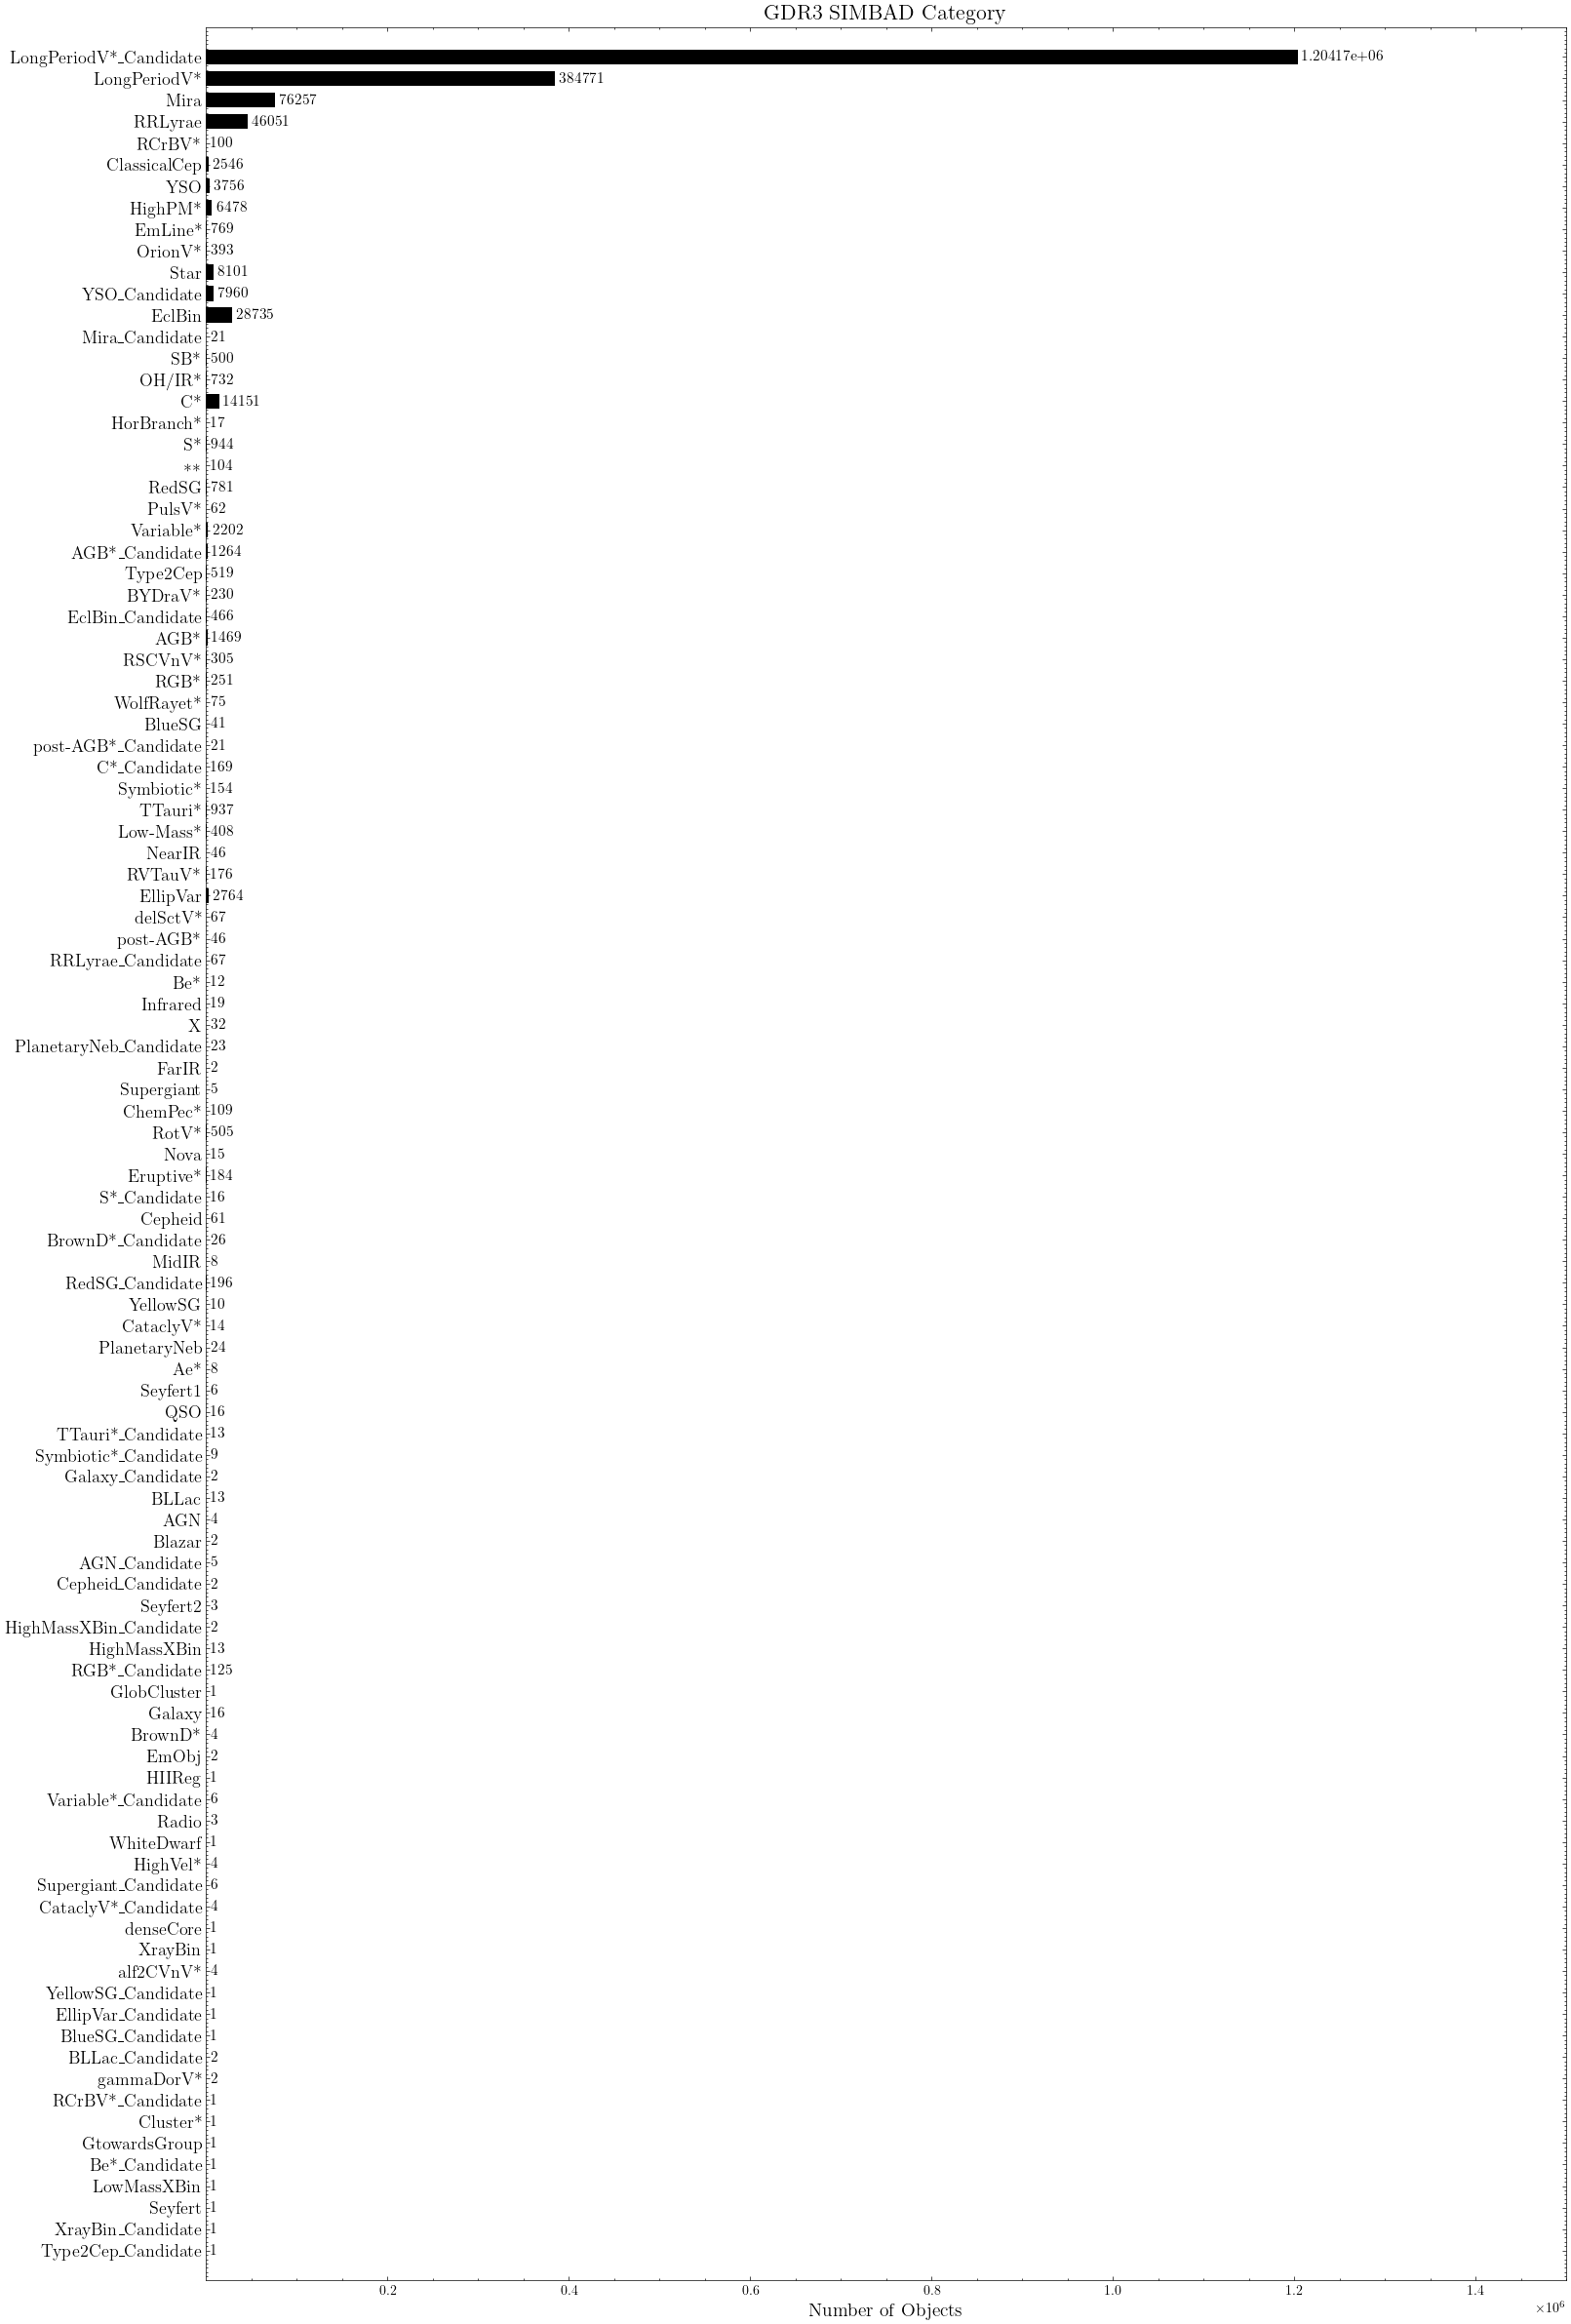

In [29]:
import matplotlib.pyplot as plt
import numpy as np

import scienceplots
plt.style.use("science")

fig, ax = plt.subplots(figsize=(18, 30))

# y_pos = np.arange(len(categories.keys()))
y_pos = np.arange(len(categories))

# hbars = ax.barh(y_pos, list(map(lambda v: len(v), categories.values())), align='center')
hbars = ax.barh(categories, counts, align='center', color="black", height=0.7)
# ax.set_yticks(y_pos, labels=categories.keys(), fontsize=11)
ax.set_yticks(y_pos, labels=categories, fontsize=13)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Objects', fontsize=14)
ax.set_xlim(1, 1.5e6)
# ax.set_xlim(1, 1e7)
# ax.set_xscale('log')
ax.set_title('GDR3 SIMBAD Category', fontsize=16)
ax.bar_label(hbars, padding=3, fontsize=11)
ax.set_ymargin(0.01)
plt.show()